In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import math
import scikitplot as skplt
import datetime
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

def test_performance(model, df):
    y = df["ChargeOff"]
    x = df.drop(['ChargeOff'], axis= 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    print(classification_report(y_test, predict, digits=3))
    print("AUC: {}".format(roc_auc_score(y_test, predict)))

def model_evaluation(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_train_ypred = model.predict(x_train)
    y_train_prob = model.predict_proba(x_train)[:,-1]

    y_test_ypred = model.predict(x_test)
    y_test_prob = model.predict_proba(x_test)[:,-1]
    y_probas = model.predict_proba(x_test)
    
    # Confussion Matrix
    
    plot_confusion_matrix(model, x_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    # ROC Curve
    
    skplt.metrics.plot_roc(y_test, y_probas,figsize=(16,9))

## Part 1: Preprocessing and Exploratory Analysis


Drop columns "Name", "City", "Zip", "Bank", "BankState", "ApprovalDate", "DisbursementDate" as these columns are non-numerical.  

Column "BalanceGross" also need to be dropped as the whole column is $0.00.

In [2]:
df = pd.read_csv('Xtrain.csv', dtype={"ApprovalFY": object})
df_y = pd.read_csv('Ytrain.csv')
df = pd.concat([df, df_y['ChargeOff']], axis=1, sort=False)
df[['Id', 'Name', 'City', 'Zip', 'ApprovalDate', 'DisbursementDate', 'BalanceGross']].head()

,Id,Name,City,Zip,ApprovalDate,DisbursementDate,BalanceGross
0,0,"NPE Realty, LLC",Pembroke Pines,33027,16-Apr-10,1-May-10,$0.00
1,1,"KEVCO CONSTRUCTION, LLC",SANDY,84094,30-Jan-10,1-Feb-10,$0.00
2,2,EAST L A SHOE REPAIR,LOS ANGELES,90022,29-Jul-02,31-Aug-02,$0.00
3,3,"RUSSLER, DANIEL C, MD",LODI,53555,10-Jun-94,31-Jul-94,$0.00
4,4,AFFORDABLE FAMILY DENISTRY LLC,LEBANON,65536,6-Feb-06,31-Mar-06,$0.00


In [3]:
df = df.drop(['Id', 'Name', 'City', 'Zip', 'ApprovalDate', 'DisbursementDate', 'BalanceGross'], axis= 1)
df.isnull().sum()

State                  0
Bank                  76
BankState             77
NAICS                  0
ApprovalFY             0
Term                   0
NoEmp                  0
NewExist               7
CreateJob              0
RetainedJob            0
FranchiseCode          0
UrbanRural             0
RevLineCr            153
LowDoc               172
DisbursementGross      0
GrAppv                 0
SBA_Appv               0
ChargeOff              0
dtype: int64

In [4]:
df.dtypes

State                 object
Bank                  object
BankState             object
NAICS                  int64
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementGross     object
GrAppv                object
SBA_Appv              object
ChargeOff              int64
dtype: object

### Handling missing and invalid values

In [5]:
# Handling non-numerical and invalid values
states = {v: k + 1 for k, v in enumerate(list(df['State'].unique()))}
df['State'].replace(states, inplace=True)
banks = {v: k for k, v in enumerate(list(df['Bank'].unique()))}
df['Bank'].replace(banks, inplace=True)
bank_states = {v: k for k, v in enumerate(list(df['BankState'].unique()))}
df['BankState'].replace(bank_states, inplace=True)
df["NAICS"] = df["NAICS"].apply(lambda x: x // 10000)
df['ApprovalFY'] = df['ApprovalFY'].replace('1976A', 1976)
df['ApprovalFY'] = df['ApprovalFY'].astype(int)
df['RevLineCr'] = np.where((df['RevLineCr'] == "N") | (df['RevLineCr'] == "Y") 
                           | (df['RevLineCr'] == "0") | (df['RevLineCr'] == "1") 
                           | (df['RevLineCr'] == "T"), df['RevLineCr'], np.nan)
df['RevLineCr'] = df['RevLineCr'].replace({'N': 0, 'Y': 1, '0': 0, '1': 1, "T": 1})
df['LowDoc'] = np.where((df['LowDoc'] == "N") | (df['LowDoc'] == "Y"), df['LowDoc'], np.nan)
df['LowDoc'] = df['LowDoc'].replace({'N': 0, 'Y': 1})
money_cols = ['DisbursementGross', 'GrAppv', 'SBA_Appv']
df[money_cols] = df[money_cols].replace('[\$,]', '', regex=True).astype(float)

# Handling missing values (replace with most frequent value)
df['LowDoc'] = np.where((df['LowDoc'].isnull()) & (df['DisbursementGross'] < 150000), 1, df['LowDoc'])
df['LowDoc'] = np.where((df['LowDoc'].isnull()) & (df['DisbursementGross'] >= 150000), 0, df['LowDoc'])
df['RevLineCr'] = np.where(df['RevLineCr'].isnull(), df['RevLineCr'].mode(), df['RevLineCr'])
df['NewExist'] = np.where(df['NewExist'].isnull(), df['NewExist'].mode(), df['NewExist'])

### Correlation

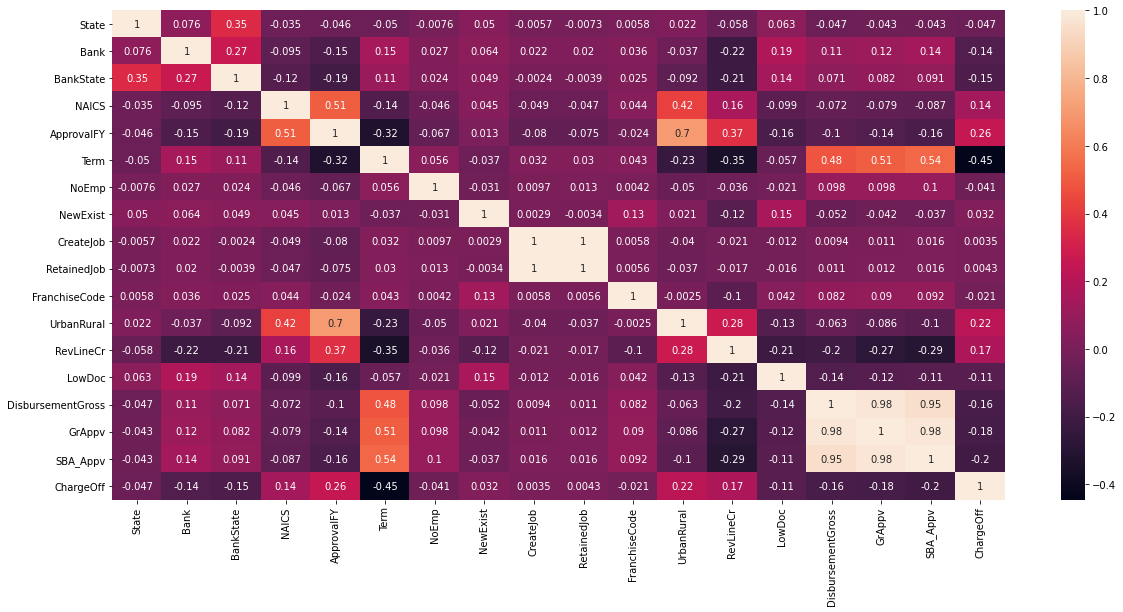

In [6]:
plt.subplots(figsize = (20,9))
sb.heatmap(df.corr(), annot=True)
plt.show()

### Exploratory Data Analysis  

**CreateJob Column**  

From the plot below, it was noted that when 0 job is create, the loan is more likely to be paid off, when only a few jobs are created (<= 5), it could means hence can simply categorize the collumn based on whether the company has created any job:    

* 0 (No Job Created): 0
* 1 (Jobs Created): more than 0

Noted there is a significant improve in the correlation

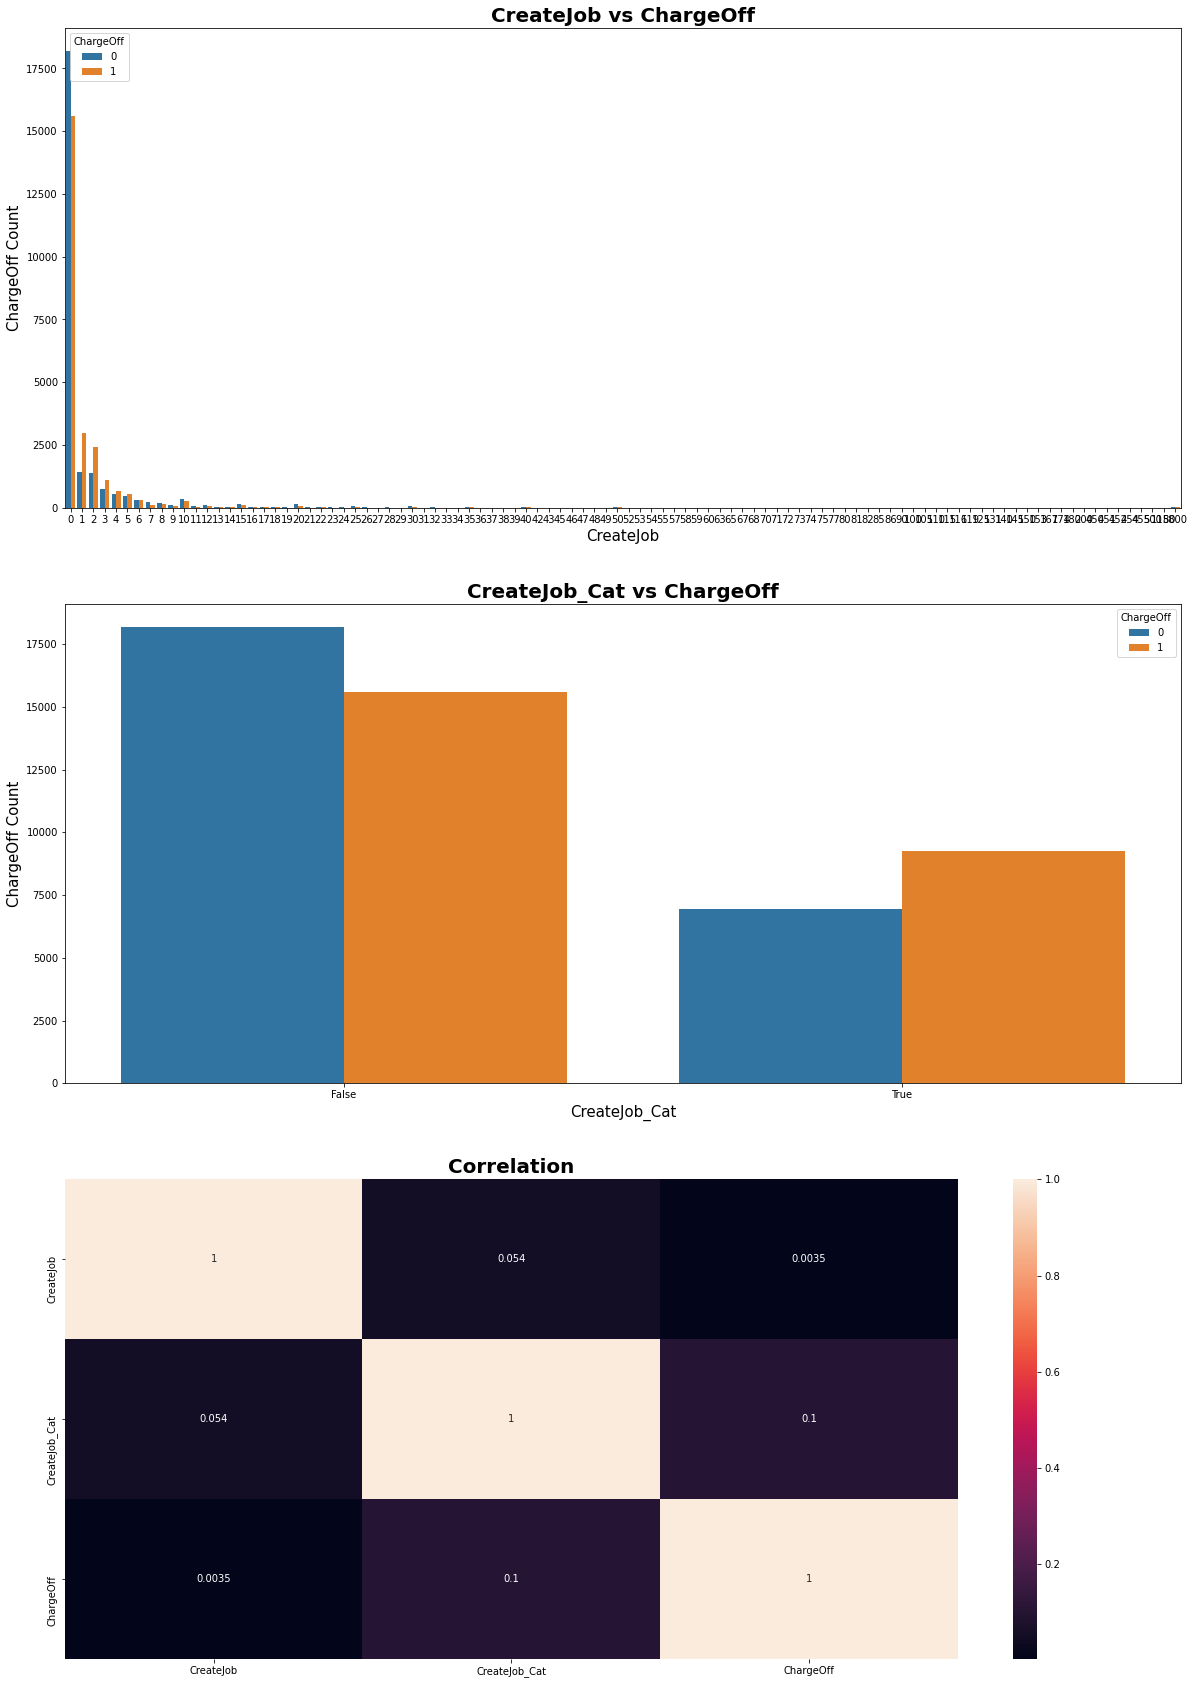

In [7]:
f, axes = plt.subplots(3, figsize=(20,30))
sb.countplot(x="CreateJob", data = df, hue = 'ChargeOff', ax=axes[0])
df["CreateJob_Cat"] = df["CreateJob"].apply(lambda x: x != 0)
sb.countplot(x="CreateJob_Cat", data = df, hue = 'ChargeOff', ax=axes[1])
sb.heatmap(df[["CreateJob", "CreateJob_Cat", "ChargeOff"]].corr(), annot=True, ax=axes[2])

axes[0].set_title('CreateJob vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize = 15)
axes[0].set_xlabel('CreateJob', fontsize = 15)
axes[1].set_title('CreateJob_Cat vs ChargeOff',fontweight="bold", size=20)
axes[1].set_ylabel('ChargeOff Count', fontsize = 15)
axes[1].set_xlabel('CreateJob_Cat', fontsize = 15)
axes[2].set_title('Correlation',fontweight="bold", size=20)
plt.show()

**RetainedJob Column**  

From the plot below, we noted the similar pattern as CreateJob, hence we can use the same approach to split the RetainedJob column in to two categories.

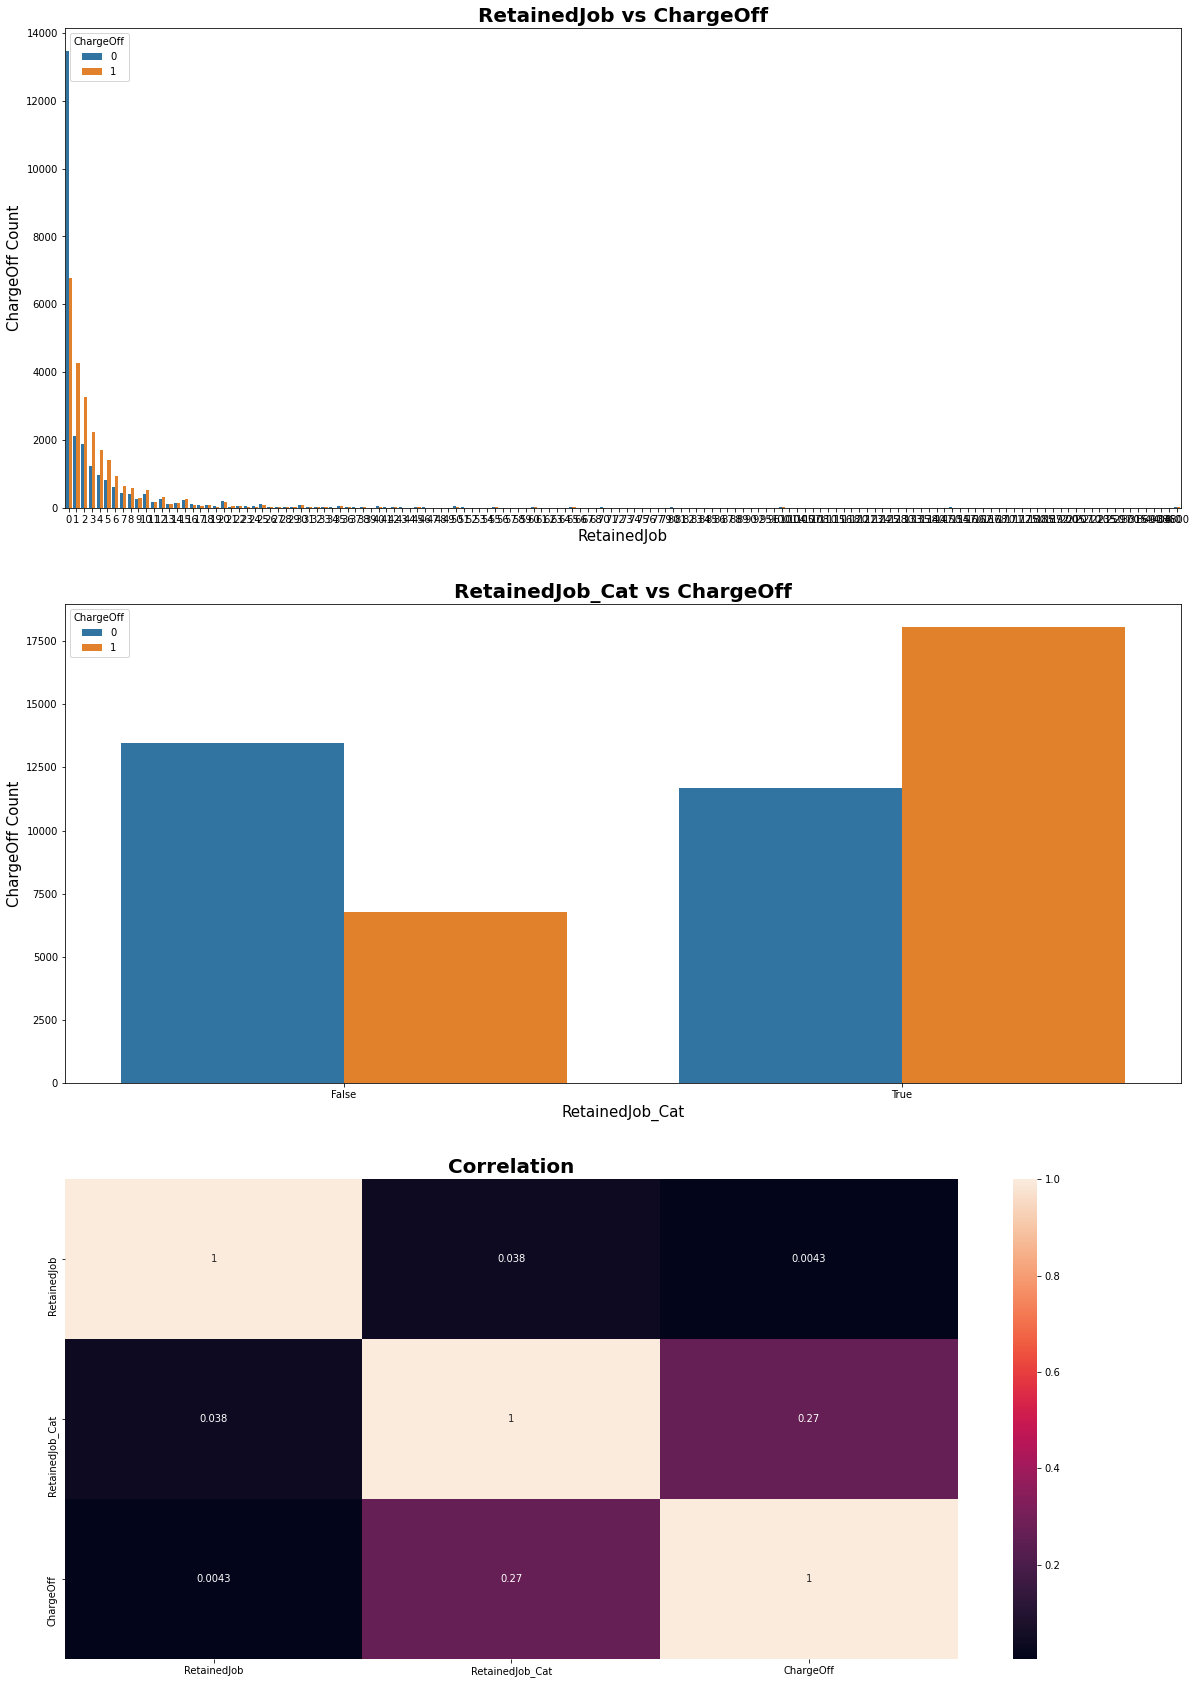

In [8]:
f, axes = plt.subplots(3, figsize=(20,30))
sb.countplot(x="RetainedJob", data = df, hue = 'ChargeOff', ax=axes[0])
df["RetainedJob_Cat"] = df["RetainedJob"].apply(lambda x: x != 0)
sb.countplot(x="RetainedJob_Cat", data = df, hue = 'ChargeOff', ax=axes[1])
sb.heatmap(df[["RetainedJob", "RetainedJob_Cat", "ChargeOff"]].corr(), annot=True, ax=axes[2])

axes[0].set_title('RetainedJob vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize = 15)
axes[0].set_xlabel('RetainedJob', fontsize = 15)
axes[1].set_title('RetainedJob_Cat vs ChargeOff',fontweight="bold", size=20)
axes[1].set_ylabel('ChargeOff Count', fontsize = 15)
axes[1].set_xlabel('RetainedJob_Cat', fontsize = 15)
axes[2].set_title('Correlation',fontweight="bold", size=20)
plt.show()

**FranchiseCode Column**  

From the information printed below, we noted the similar pattern as CreateJob, hence we can use the same approach to split the FranchiseCode column in to two categories.

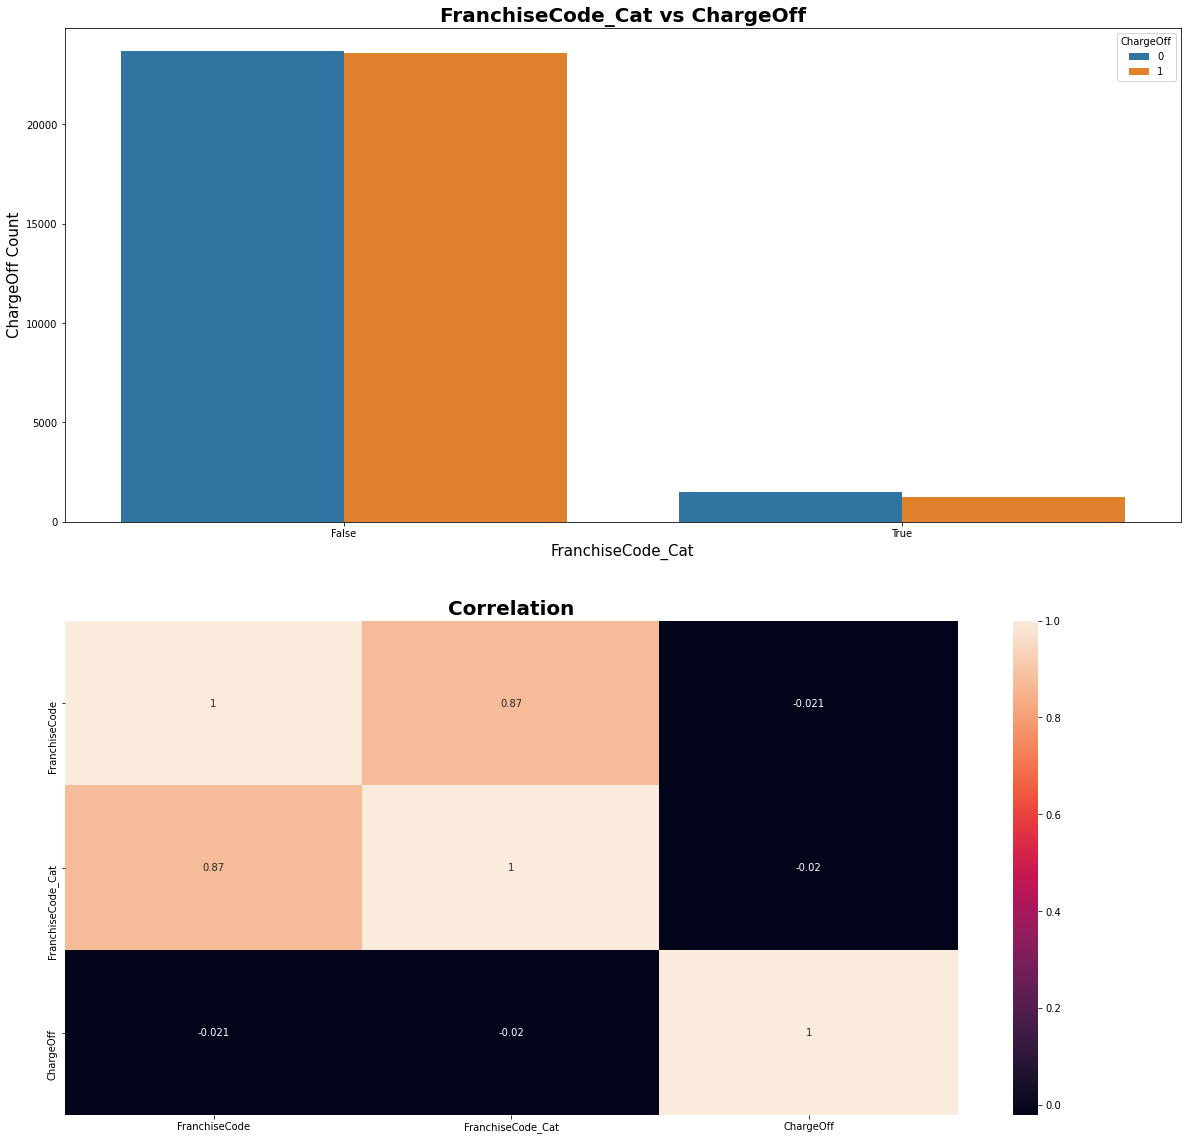

In [9]:
# if code=0 or 1 means no franchise
df["FranchiseCode_Cat"] = df["FranchiseCode"].apply(lambda x: x != 0 and x != 1)
f, axes = plt.subplots(2, figsize=(20,20))
sb.countplot(x="FranchiseCode_Cat", data = df, hue = 'ChargeOff', ax=axes[0])
sb.heatmap(df[["FranchiseCode", "FranchiseCode_Cat", "ChargeOff"]].corr(), annot=True, ax=axes[1])

axes[0].set_title('FranchiseCode_Cat vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize = 15)
axes[0].set_xlabel('FranchiseCode_Cat', fontsize = 15)
axes[1].set_title('Correlation',fontweight="bold", size=20)
plt.show()

**SBA_Appv and GrAppv Columns**  

It was noted that both columns is related to the amount granted to the company, The SBA guaranteed amount (SBA_Appv) is a part of the Gross amount (GrAppv), hence we can calculate the relationship between them.

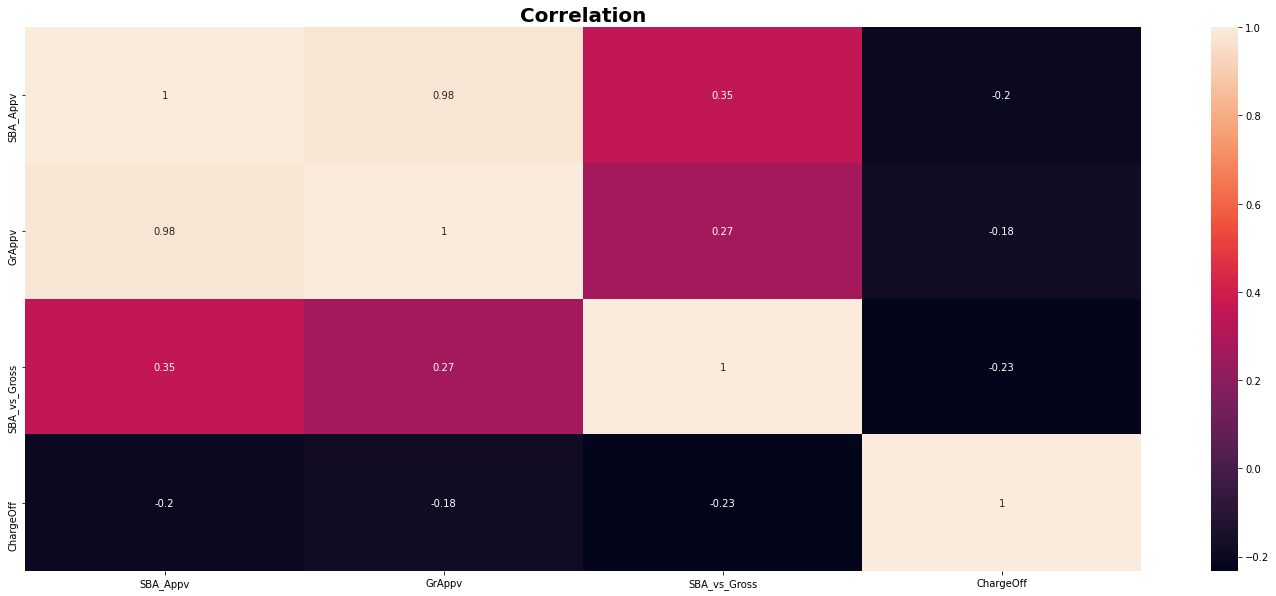

In [10]:
df['SBA_vs_Gross'] = df['SBA_Appv']/df['GrAppv']
f, ax = plt.subplots(figsize=(25,10))
sb.heatmap(df[['SBA_Appv', 'GrAppv', "SBA_vs_Gross", "ChargeOff"]].corr(), annot=True)

ax.set_title('Correlation',fontweight="bold", size=20)
plt.show()

## Part 2: Feature Selection

### Correlation between the parameters in the dataset

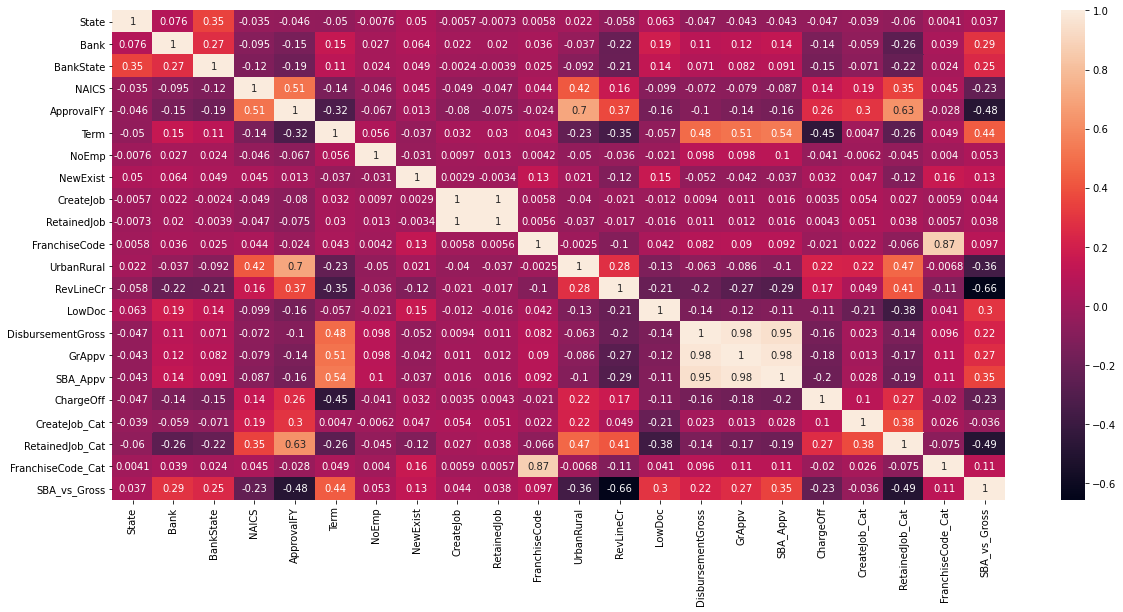

In [11]:
plt.subplots(figsize = (20,9))
sb.heatmap(df.corr(), annot=True)
plt.show()

### Feature Importance

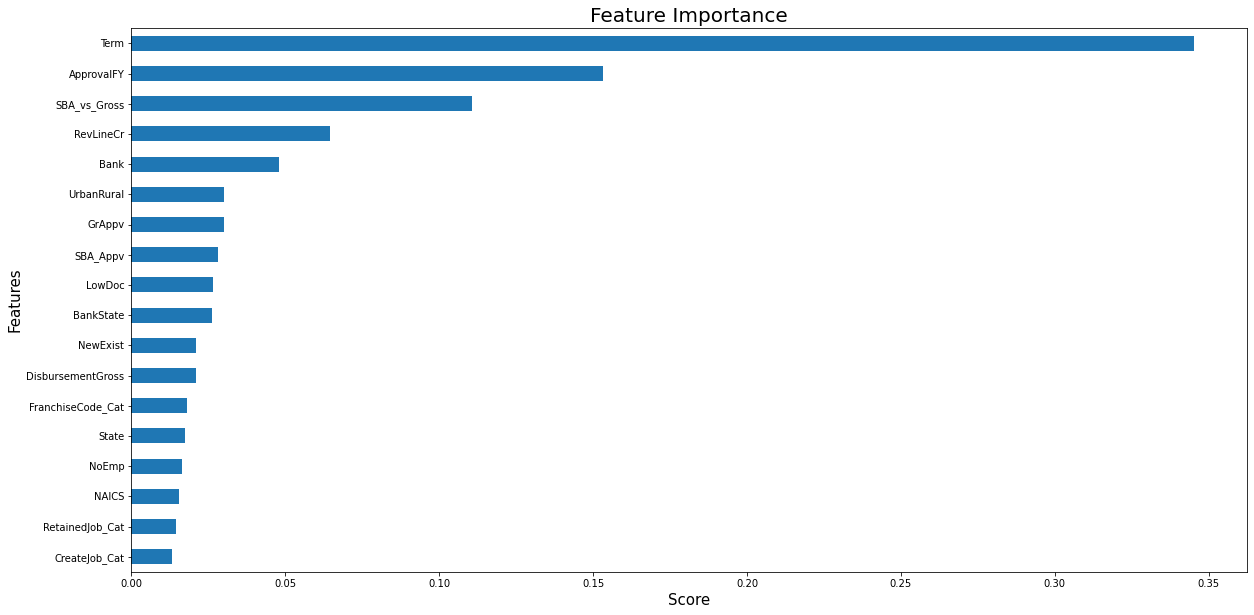

In [12]:
df = df.drop(['CreateJob', 'RetainedJob', 'FranchiseCode'], axis=1)
model = XGBClassifier()
y = df['ChargeOff']
x = df.drop(columns=['ChargeOff'], axis=1)

model.fit(x,y)
feat_importances = pd.Series(model.feature_importances_, index = x.columns)
f, ax = plt.subplots(figsize = (20,10))

feat_importances.sort_values().plot(kind = 'barh')

plt.title('Feature Importance', fontsize = 20)
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Score', fontsize = 15)

plt.show()

## Part 3: Modelling

In [13]:
y = df["ChargeOff"]
x = df.drop(['ChargeOff'], axis= 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

Logistic Regression Classifier: 


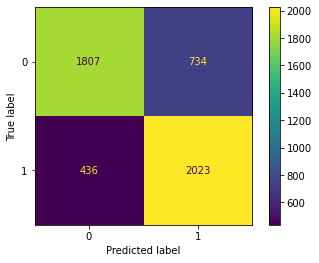

Classification Report: 
               precision    recall  f1-score   support

           0      0.806     0.711     0.755      2541
           1      0.734     0.823     0.776      2459

    accuracy                          0.766      5000
   macro avg      0.770     0.767     0.766      5000
weighted avg      0.770     0.766     0.765      5000



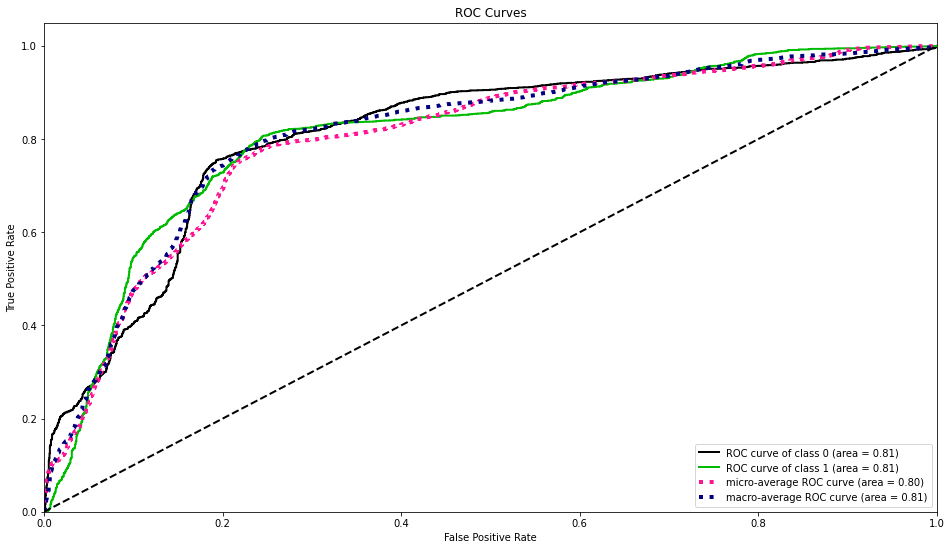

In [14]:
print("Logistic Regression Classifier: ")
model = LogisticRegression()
model_evaluation(model,x_train, y_train,x_test, y_test)

Gaussian Naive Bayes Classifier: 


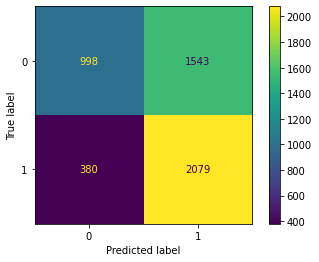

Classification Report: 
               precision    recall  f1-score   support

           0      0.724     0.393     0.509      2541
           1      0.574     0.845     0.684      2459

    accuracy                          0.615      5000
   macro avg      0.649     0.619     0.597      5000
weighted avg      0.650     0.615     0.595      5000



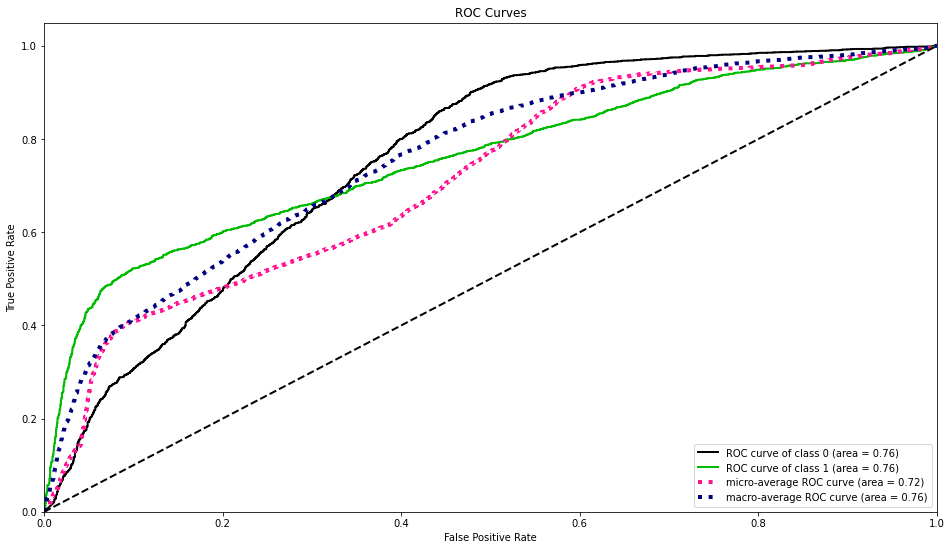

In [15]:
print("Gaussian Naive Bayes Classifier: ")
model = GaussianNB()
model_evaluation(model,x_train, y_train,x_test, y_test)

K-Neighbors Classifier: 


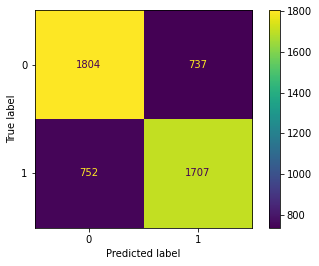

Classification Report: 
               precision    recall  f1-score   support

           0      0.706     0.710     0.708      2541
           1      0.698     0.694     0.696      2459

    accuracy                          0.702      5000
   macro avg      0.702     0.702     0.702      5000
weighted avg      0.702     0.702     0.702      5000



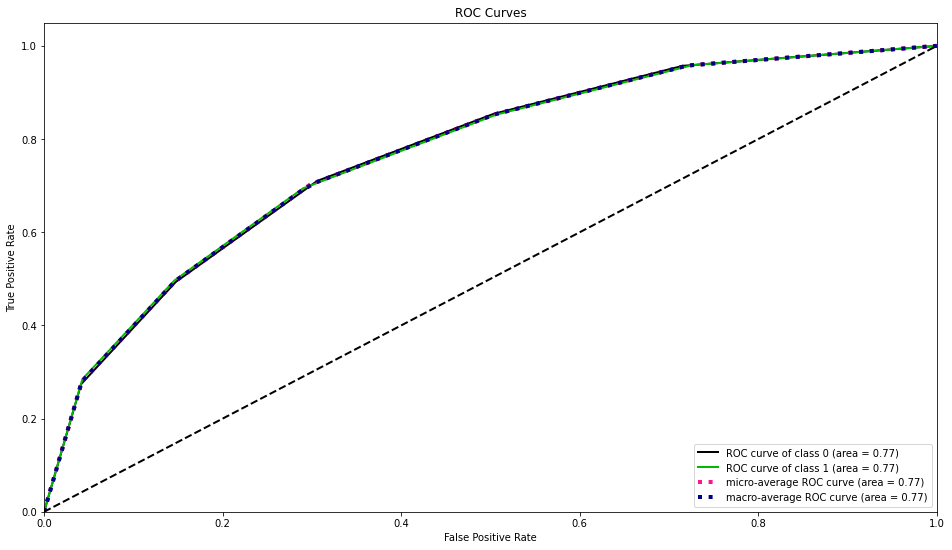

In [16]:
print("K-Neighbors Classifier: ")
model = KNeighborsClassifier()
model_evaluation(model,x_train, y_train,x_test, y_test)

Random Forest Classifier: 


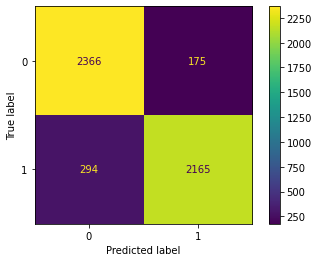

Classification Report: 
               precision    recall  f1-score   support

           0      0.889     0.931     0.910      2541
           1      0.925     0.880     0.902      2459

    accuracy                          0.906      5000
   macro avg      0.907     0.906     0.906      5000
weighted avg      0.907     0.906     0.906      5000



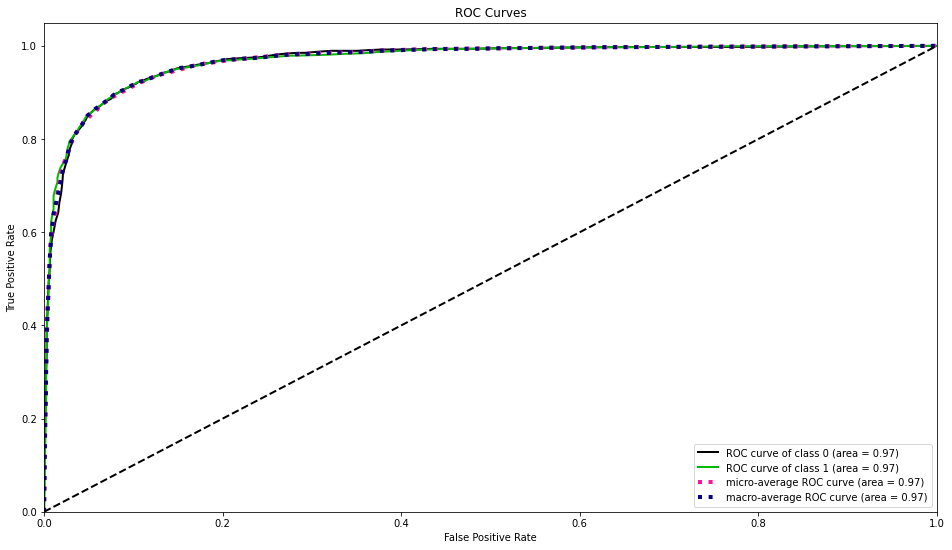

In [17]:
print("Random Forest Classifier: ")
model = RandomForestClassifier()
model_evaluation(model,x_train, y_train,x_test, y_test)

XGBooster Classifier: 


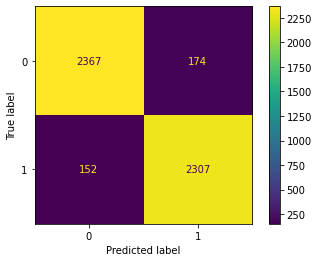

Classification Report: 
               precision    recall  f1-score   support

           0      0.940     0.932     0.936      2541
           1      0.930     0.938     0.934      2459

    accuracy                          0.935      5000
   macro avg      0.935     0.935     0.935      5000
weighted avg      0.935     0.935     0.935      5000



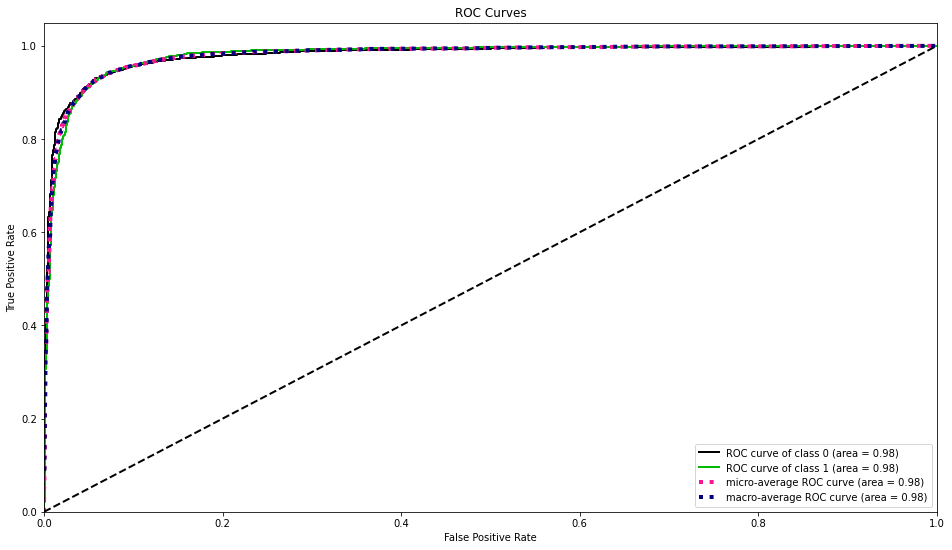

In [18]:
print("XGBooster Classifier: ")
model = XGBClassifier()
model_evaluation(model,x_train, y_train,x_test, y_test)